# PROJECT

**NOME:** Christian

**COGNOME:** Uccheddu

**MATRICOLA:** 800428

> This project is based on the code of Prof. Samuel Albani left during the lessons.

First the necessary libraries are imported in which the relative versions are also printed so that everything is reproducible.

In [20]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats
import scipy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import seaborn
from pylab import *
import matplotlib.gridspec as gridspec
from cartopy.util import add_cyclic_point
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import pmdarima as pm
import statsmodels

import datetime as dtm
from datetime import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import matplotlib
import cartopy
import xarray as xr

pd.options.mode.chained_assignment = None

print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)
print("Cartopy version:",cartopy.__version__)
print("Geoandas version:",gpd.__version__)
print("Matplotlib version:",matplotlib.__version__)
print("Scipy version:",scipy.__version__)
print("Seaborn version:",sns.__version__)
print("Xarray version:",xr.__version__)
print("Pmdarima version:",pm.__version__)
print("Statsmodels version:",statsmodels.__version__)

Pandas version: 1.2.3
Numpy version: 1.19.2
Cartopy version: 0.18.0
Geoandas version: 0.8.1
Matplotlib version: 3.3.4
Scipy version: 1.6.1
Seaborn version: 0.11.1
Xarray version: 0.17.0
Pmdarima version: 1.8.0
Statsmodels version: 0.12.2


## Import data

At this point I import the 4 files that contain the three models. In particular, the last model is divided into two files which will then be concatenated to have a single model.

In [2]:
modfile='dati/ts_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
modfile2='dati/ts_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc'
modfile3='dati/ts_Amon_MIROC6_historical_r1i1p1f1_gn_185001-194912.nc'
modfile4='dati/ts_Amon_MIROC6_historical_r1i1p1f1_gn_195001-201412.nc'

Now I extract the time series that we will need to visualize the data on graphs. I also concatenate the third and fourth time series into a single time series.

In [3]:
d1d = xr.open_dataset(modfile)
ts1 = d1d.ts  

d2d = xr.open_dataset(modfile2)
ts2 = d2d.ts  

d3d = xr.open_dataset(modfile3)
ts3 = d3d.ts  

d4d = xr.open_dataset(modfile4)
ts4 = d4d.ts  

m5 = xr.concat([ts3, ts4], dim = "time")

I make a plot of the means of the three time series so that I can visualize them on a map. In particular they have been colored with the "coolwarm" colormap which gives a good idea of which areas are warmer than others. I leave all three in the same figure using matplotlib's **gridspec** which allows you to define fully customizable grids.

/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


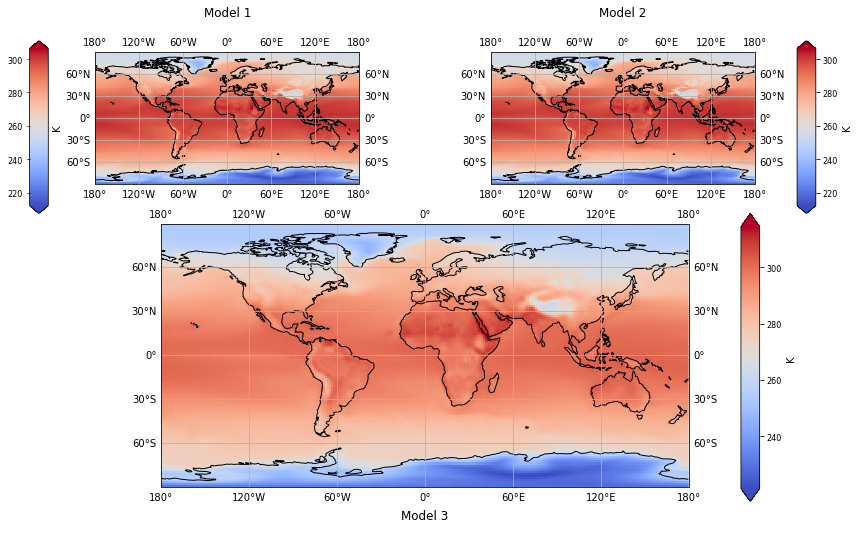

In [4]:
# Define the figure and the grid to fill with the three different plot
fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1, 2], hspace = 0.2)

# Define the color map
cmap = mpl.cm.coolwarm

# Plot of the first time series
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax0.set_title('Model 1\n')
ax0.set_global()
mm0 = ax0.pcolormesh(ts1.lon, ts1.lat, ts1.mean(axis = 0), \
                   transform=ccrs.PlateCarree(),cmap=cmap)  
ax0.coastlines()
ax0.gridlines(draw_labels=True)
cbar_ax0 = fig.add_axes([0.09, 0.6, 0.02, 0.30]) #[left, bottom, width, height]
cbar0 = fig.colorbar(mm0, cax=cbar_ax0, extend='both', orientation='vertical')
cbar0.set_label('K')
cbar0.ax.tick_params(labelsize=8)
cbar_ax0.yaxis.tick_left()

# Plot of the second time series
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax1.set_title('Model 2\n')
ax1.set_global()
mm1 = ax1.pcolormesh(ts1.lon, ts1.lat, ts1.mean(axis = 0), \
                   transform=ccrs.PlateCarree(),cmap=cmap)  
ax1.coastlines()
ax1.gridlines(draw_labels=True)
cbar_ax1 = fig.add_axes([0.91, 0.6, 0.02, 0.30]) #[left, bottom, width, height]
cbar1 = fig.colorbar(mm1, cax=cbar_ax1, extend='both', orientation='vertical')
cbar1.set_label('K')
cbar1.ax.tick_params(labelsize=8)

# Plot of the third time series
ax2 = fig.add_subplot(gs[1:, :], projection=ccrs.PlateCarree())
ax2.set_title("Model 3\n", y=-0.2)
ax2.set_global()
mm2 = ax2.pcolormesh(m5.lon, m5.lat, m5.mean(axis = 0), \
                   transform=ccrs.PlateCarree(),cmap=cmap )  
ax2.coastlines()
ax2.gridlines(draw_labels=True)
cbar_ax2 = fig.add_axes([0.85, 0.1, 0.02, 0.50]) #[left, bottom, width, height]
cbar2 = fig.colorbar(mm2, cax=cbar_ax2, extend='both', orientation='vertical')
cbar2.set_label('K')
cbar2.ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

At this point I do the regridding operation bringing all three time series to a single grid in order to create the ensemble model in a simpler way.

In [5]:
ts1_regridded = ts1.copy()
ts2_regridded = ts2.interp(lat=ts1.lat, lon=ts1.lon, method='linear')
ts3_regridded = m5.interp(lat=ts1.lat, lon=ts1.lon, method='linear')

First, I separately extrapolate the three time series by averaging along the time dimension by aggregating by year. Subsequently I aggregate these three time series spatially (always distinctly) in order to have a single value for each year for each time series.


In [6]:
ens_mean_month = np.nanmean([ts1_regridded.mean(("lon", "lat")), ts2_regridded.mean(("lon", "lat")), ts3_regridded.mean(("lon", "lat"))], axis=0)

In [7]:
ens_month = pd.concat([pd.Series(ts1_regridded.time, name = "time"), pd.Series(ens_mean_month, name = "Ensemble mean")], axis = 1, ignore_index = True)
ens_month.columns = ['time', 'Ensemble historical']
ens_month['time'] = pd.to_datetime(ens_month['time'], format = "%Y-%m-%d %H:%M:%S")
ens_month = ens_month[ens_month['time'].dt.year >= 1901]
ens_month['year'] = ens_month['time'].dt.year
ens_month['month'] = ens_month['time'].dt.month
ens_month.drop("time", axis = 1, inplace = True)

ens_month.head()

,Ensemble historical,year,month
612,277.620591,1901,1
613,276.748314,1901,2
614,276.547885,1901,3
615,277.742982,1901,4
616,279.477199,1901,5


We keep the historical series of monthly anomalies since working with Machine Learning techniques it is better to have more data.

In [8]:
ref_month = ens_month.loc[(ens_month['year'] >= 1961) & (ens_month['year'] <= 1990)].groupby("month").mean().reset_index().drop("year", axis = 1)
ref_month.columns = ['month', 'reference temperature']
ref_month

,month,reference temperature
0,1,277.564074
1,2,276.982217
2,3,276.806702
3,4,277.878794
4,5,279.670381
5,6,281.223710
6,7,281.735931
7,8,281.356015
8,9,280.205231
9,10,279.032454


In [9]:
anomaly_month = pd.merge(ens_month, ref_month, on = "month", how = "inner")
anomaly_month['anomaly'] = anomaly_month['Ensemble historical'] - anomaly_month['reference temperature']
anomaly_month = anomaly_month.sort_values(['year', 'month']).reset_index().drop("index", axis = 1)

I merge the two datasets in order to make the difference with the corresponding month and have the final dataset that contains the historical series of anomalies for each year.

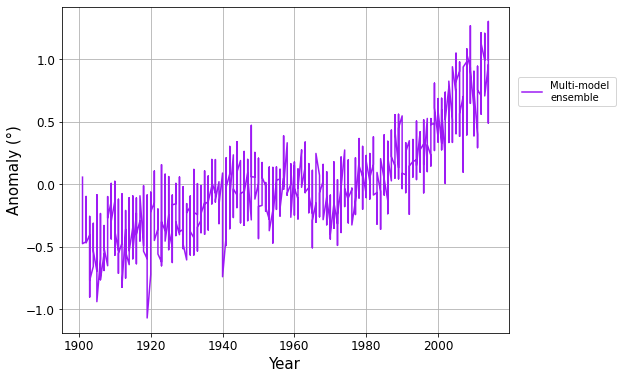

In [16]:
plt.figure(figsize = (8,6))

p1, = plt.plot(anomaly_month['year'], anomaly_month['anomaly'], color = "#9D1AF4", ls = "-")

plt.legend([p1], [ "Multi-model \nensemble"],
           bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Anomaly (°)", fontsize = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.grid()

## ARIMA

I build the dataframe so that it can be easily passed to the ARIMA models. In particular, I use the date in datetime format as an index and I keep the column **anomaly** the column in which the historical series is present.

In [12]:
df = anomaly_month.copy()
df = df.drop(['Ensemble historical', 'reference temperature'], axis = 1)
df['date'] = pd.to_datetime(df['year'] * 10000 + df['month'] * 100 + 1, format="%Y%m%d")
df = df.drop(['year', 'month'], axis = 1)
df.set_index('date', inplace=True)

In [13]:
df

,anomaly
date,
1901-01-01,0.056517
1901-02-01,-0.233903
1901-03-01,-0.258817
1901-04-01,-0.135811
1901-05-01,-0.193181
...,...
2014-08-01,0.795933
2014-09-01,0.949292
2014-10-01,1.302075


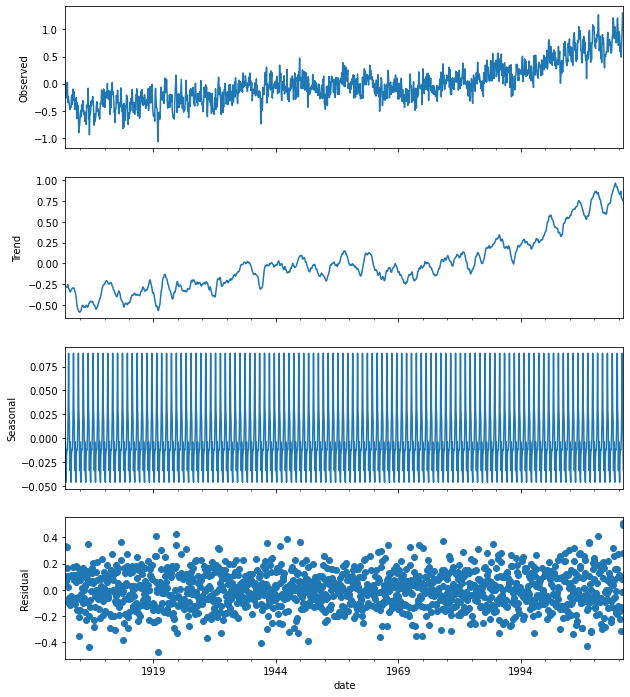

In [14]:
# Additive Decomposition 
result_add = seasonal_decompose(df['anomaly'], model='additive', extrapolate_trend='freq')

# Plot
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,12))
result_add.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_add.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_add.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_add.resid.plot(ax=axes[3], legend=False, style='o')
axes[3].set_ylabel('Residual')
plt.show()

In [15]:
smodel = pm.auto_arima(df['anomaly'], start_p=1, start_q=1,
                       test='adf',
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.84 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-190.470, Time=0.24 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-665.476, Time=1.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-941.637, Time=1.68 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-189.874, Time=0.15 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-296.826, Time=0.34 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-939.650, Time=2.68 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-939.653, Time=6.70 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-592.593, Time=0.98 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=-939.457, Time=11.29 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-754.417, Time=1.87 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=-1039.068, Time=2.02 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=-348.826, Time=0.47 sec
 ARIMA(0,0,2)(1,1,1)[12] intercept   : AIC=-1037.339, Time=4.52 sec
 ARIMA(0,0,2)(0,1,2)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1368
Model:             SARIMAX(0, 0, 3)x(0, 1, [1], 12)   Log Likelihood                 539.267
Date:                              Fri, 23 Apr 2021   AIC                          -1066.533
Time:                                      18:17:07   BIC                          -1035.259
Sample:                                           0   HQIC                         -1054.824
                                             - 1368                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0107      0.001      8.231      0.000       0.008       0.013
ma.L1          0.3456      0.027     12.660      0.000       0.292       0.399
ma.L2          0.2675      0.030      9.011      0.000       0.209       0.326
ma.L3          0.1378      0.026      5.252      0.000       0.086       0.189
ma.S.L12      -0.8402      0.016    -52.974      0.000      -0.871      -0.809
sigma2         0.0261      0.001     25.721      0.000       0.024       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):                 3.51
Prob(Q):                              0.38   Prob(JB):                         0.17
Heteroskedasticity (H):               1.12   Skew:                            -0.12
Prob(H) (two-sided):                  0.24   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

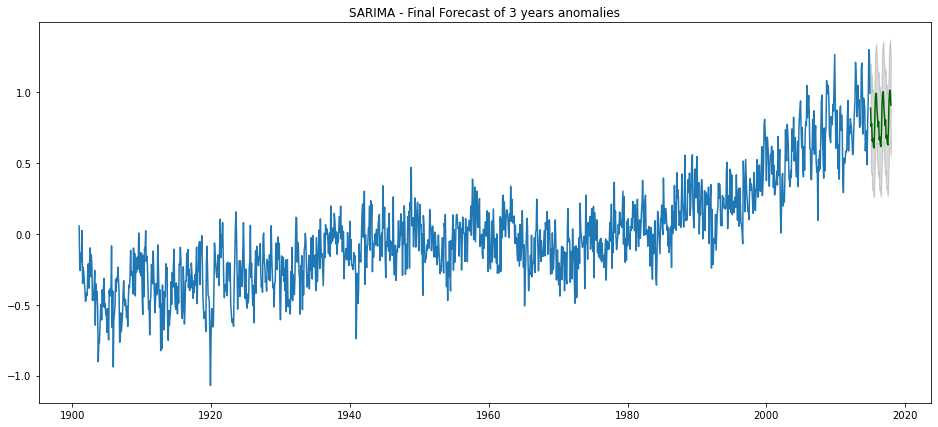

In [17]:
n_periods = 36
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df['anomaly'].index[-1], periods=n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(df['anomaly'])
#plt.plot(future, color='red')

plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of 3 years anomalies")
plt.show()

Proviamo ad aggiungere dei regressori esterni

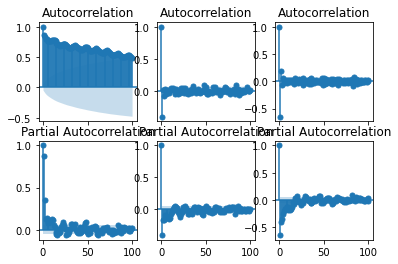

In [18]:
fig, axes = plt.subplots(2, 3, sharex=True)

plot_acf(df['anomaly'].dropna(),  lags=100, ax=axes[0,0])
plot_acf(df['anomaly'].diff().dropna(), lags=100, ax=axes[0,1])
plot_acf(df['anomaly'].diff().diff().dropna(), lags=100, ax=axes[0,2])

plot_pacf(df['anomaly'].dropna(),  lags=100, ax=axes[1,0])
plot_pacf(df['anomaly'].diff().dropna(), lags=100, ax=axes[1,1])
plot_pacf(df['anomaly'].diff().diff().dropna(), lags=100, ax=axes[1,2])

plt.show()

Sembra che ci voglia un AR(2), pensiamo già a come inserire dei regressori esterni, possibilmente come armoniche

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df['anomaly'], order = (2,1,1), seasonal_order = (2,0,1,12),trend = "t", dates = df.index)
res = model.fit()
print(res.summary())

/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                    SARIMAX Results                                     
Dep. Variable:                          anomaly   No. Observations:                 1368
Model:             ARIMA(2, 1, 1)x(2, 0, 1, 12)   Log Likelihood                 620.551
Date:                          Fri, 23 Apr 2021   AIC                          -1225.102
Time:                                  18:17:26   BIC                          -1183.339
Sample:                              01-01-1901   HQIC                         -1209.472
                                   - 12-01-2014                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0009      0.001      1.368      0.171      -0.000       0.002
ar.L1          0.3114      0.027     11.509      0.

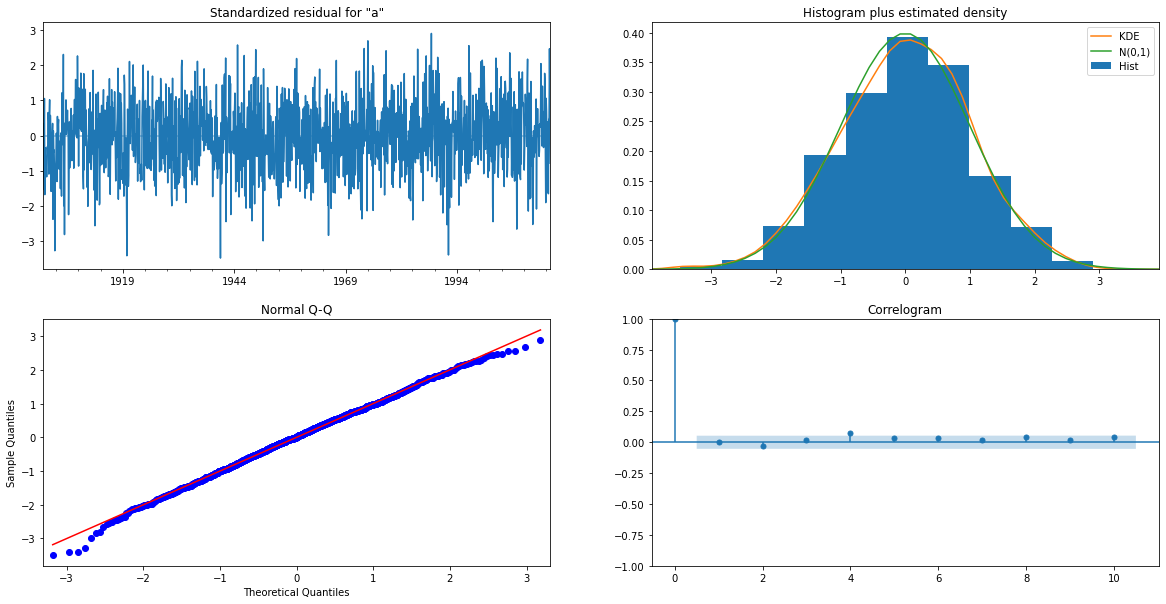

In [20]:
res.plot_diagnostics(figsize=(20,10))
plt.show()

C'è un forte ritardo sul primo, bisognerebbe aggiungere una differenziazione

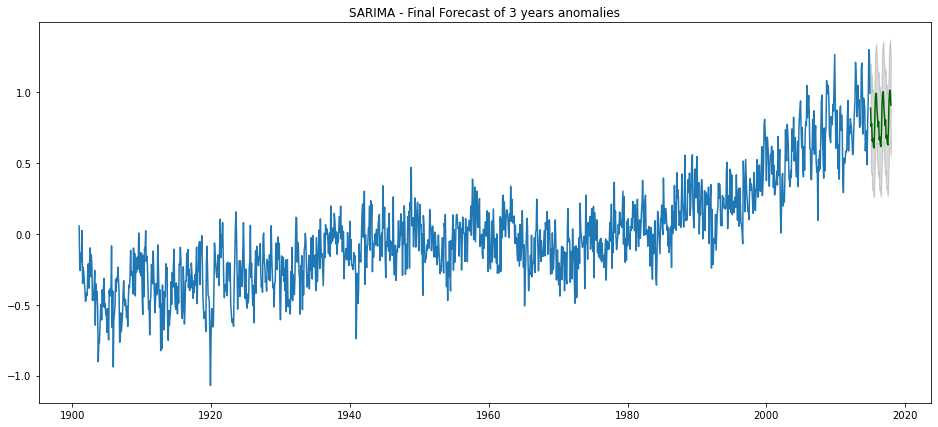

In [21]:
n_periods = 36
fittedparam_termsfint = res.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df['anomaly'].index[-1], periods=n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(df['anomaly'])
#plt.plot(future, color='red')

plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of 3 years anomalies")
plt.show()

# Prophet

In [65]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [60]:
df = anomaly_month.copy()
df = df.drop(['Ensemble historical', 'reference temperature'], axis = 1)
df['ds'] = pd.to_datetime(df['year'] * 10000 + df['month'] * 100 + 1, format="%Y%m%d")
df = df.drop(['year', 'month'], axis = 1)
df.columns = ['y', 'ds']

In [61]:
model2 = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=2) 
model2.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
model2.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [62]:
forecast = model2.predict(future)

In [63]:
# define the period for which we want a prediction
future = model2.make_future_dataframe(freq='M', periods=36)

future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
forecast = model2.predict(future)

          ds      yhat  yhat_lower  yhat_upper
0 1901-01-01 -0.211352   -0.544484    0.112731
1 1901-02-01 -0.241589   -0.560955    0.068488
2 1901-03-01 -0.319239   -0.634333    0.000104
3 1901-04-01 -0.275426   -0.581683    0.052545
4 1901-05-01 -0.286798   -0.608625    0.015773


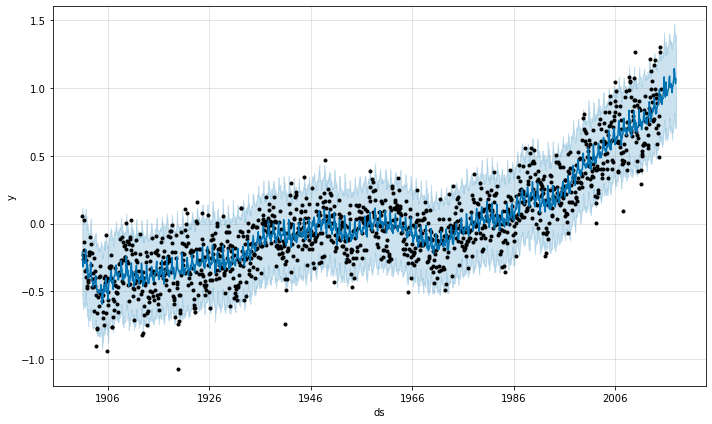

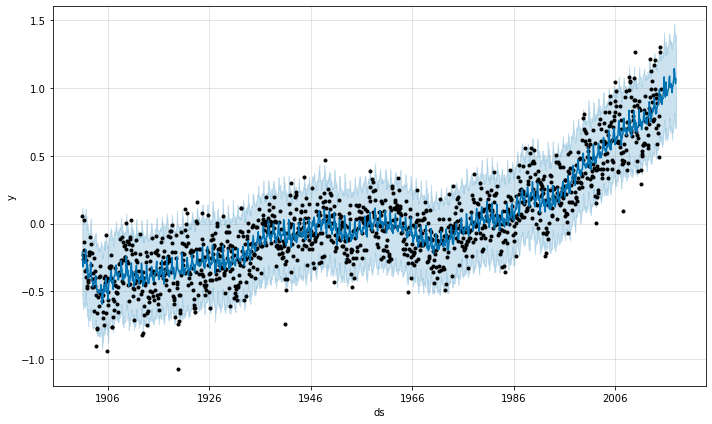

In [64]:
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model2.plot(forecast)

# LSTM

# KNN